<h1> HubMap - Hacking the Kidney </h1>
<h3> Goal - Mapping the human body at function tissue unit level - detect glomeruli FTUs in kidney </h3>

Implementation of Kaggle Notebook - Innovation Prize Winner - Deep Flash2 <br>
Description - Train 5 fold model on rescaled images <br>
Input - train.csv (csv file containing rle format mask), HuBMAP-20-dataset_information.csv (csv containing meta data about the images), Downscaled images and masks, roi-stats.csv (csv containing pdfs for each image), wandb credentials, download deepflash2 library (link - https://www.kaggle.com/matjes/deepflash2-lfs), hubmap_loss_metrics.py <br>
Output - trained models

<b>How to use?</b><br> 
Change the basepath to where your data lives and you're good to go. <br>

Link to the original notebook -  https://www.kaggle.com/matjes/hubmap-deepflash2-train/data?scriptVersionId=63051354

<b> What is different from the original notebook? </b><br>
Could not find the augmentation package, hence, some augmentations are excluded. <hr>

<h6> Step 1 - Installation and package loading <h6>

In [1]:
!pip install -q input/deepflash2-lfs
!git clone https://github.com/qubvel/segmentation_models.pytorch.git
!pip install -q ./segmentation_models.pytorch
!pip install git+https://github.com/p-sodmann/Augmedical

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
fatal: destination path 'segmentation_models.pytorch' already exists and is not an empty directory.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


  Running command git clone -q https://github.com/p-sodmann/Augmedical 'C:\Users\soodn\AppData\Local\Temp\pip-req-build-tqlh3e22'



  Cloning https://github.com/p-sodmann/Augmedical to c:\users\soodn\appdata\local\temp\pip-req-build-tqlh3e22
  Resolved https://github.com/p-sodmann/Augmedical to commit 2c1231f6f2a9dafaa0233bcdafd4b8c81693c75c


In [2]:
import torch
import zarr, cv2, random
import numpy as np, pandas as pd
import segmentation_models_pytorch as smp
from fastai.vision.all import *
from deepflash2.all import *
from scipy import interpolate
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
from hubmap_loss_metrics import *
from augmedical.transforms.transforms import ImageTransform
from augmedical.colors.colors import Deconvolution
from tqdm.auto import tqdm
import albumentations as A

In [3]:
import wandb
# Go to wandb and get this key for your username
wandb.login(key="6883cb3173ae477ba8d8bde16206f1eaa23dc106")
from fastai.callback.wandb import *

wandb: Currently logged in as: soodn (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\soodn/.netrc


<h6> Step 2 - Make patches of the image file, and define helper functions </h6>

In [4]:
# Patch for deepflash2 'DeformationField' class, see https://fastcore.fast.ai/basics.html#patch
@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [5]:
from random import shuffle

class HubmapRandomTileDataset(Dataset):
    """
    Pytorch Dataset that creates random tiles with augmentations from the input images.
    """
    n_inp = 1
    def __init__(self, 
                 files,
                 label_path,
                 cdf_path, 
                 df_stats, 
                 sample_multiplier=50,
                 tile_shape = (512,512),
                 scale = 1,
                 flip = True,                                
                 rotation_range_deg = (0, 360),     
                 deformation_grid = (150,150), 
                 deformation_magnitude = (10,10),
                 value_minimum_range = (0, 0), 
                 value_maximum_range = (1, 1), 
                 value_slope_range = (1, 1),
                 albumentations_tfms=None,
                 augmedical_transforms=None,
                 deconv=True,
                 **kwargs
                ):
        store_attr('files, df_stats, sample_multiplier, tile_shape, scale, albumentations_tfms')
        store_attr('flip, rotation_range_deg, deformation_grid, deformation_magnitude, value_minimum_range, value_maximum_range, value_slope_range')
        
        self.data = zarr.open_group(self.files[0].parent.as_posix(), mode='r')
        self.labels = zarr.open_group(label_path)
        self.cdfs = zarr.open_group(cdf_path)
        
        self.indices = []
        self.center_indices = []
        self.df_stats = self.df_stats[self.df_stats.index.isin([f.stem for f in self.files],  level=0)]
        print('Preparing sampling')
        for key, grp in self.df_stats.groupby('idx'):
            for (idx, i), row in grp.iterrows():
                self.indices.append(idx)
                self.center_indices.append(i)
            for _ in range(self.sample_multiplier):
                self.indices.append(idx)
                self.center_indices.append(None)         
        self.on_epoch_end()
        
        # briefly disable transformations to calc stats
        self.albumentations_tfms = None   
        self.augmedical_transforms = None
        self.deconv = False
        
        if deconv:
            print('Calculating stats for stain normalization w/o albumentation tfms')
            self.dkv_stats = {}
            self.dkv = Deconvolution()
            for f in progress_bar(self.files):
                idxs = [i for i, x in enumerate(self.indices) if x==f.stem]
                t = []
                for i in tqdm(idxs[:100], leave=False):
                    t.append(self[i][0].numpy().transpose(1,2,0))
                
                self.dkv_stats[f.stem] = self.dkv.fit(t)
                
            self.deconv = True
        
            print(self.dkv_stats)
        
        self.albumentations_tfms = albumentations_tfms   
        self.augmedical_transforms = augmedical_transforms
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx): idx = idx.tolist()       
        file_name = self.indices[idx]
        center_idx = self.center_indices[idx]

        img = self.data[file_name]
        n_channels = img.shape[-1]

        lbl = self.labels[file_name]
        cdf = self.cdfs[file_name]

        center = self.random_center(cdf[:], lbl.shape, scale=512, file=file_name, center_idx=center_idx)
        X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
        Y = self.deformationField.apply(lbl, center, (0,0), 0)

        if self.albumentations_tfms:
            augmented = self.albumentations_tfms(image=(X*255).astype('uint8'),mask=Y.astype('uint8'))
            X = (augmented['image']/255)
            Y = augmented['mask']
            
        if self.deconv:
            d_mean,  d_std = self.dkv_stats[file_name]
            X = self.dkv.apply(X, d_mean, 2*d_std)
            X = np.clip(X, a_min=-5, a_max=5)
            
        X = X.transpose(2, 0, 1).astype('float32')
        Y = Y.astype('int64')
        
        X = TensorImage(X)
        
        if self.augmedical_transforms:
            for transform in self.augmedical_transforms:
                X = transform(X)
        
        return  X, TensorMask(Y)
        
    def random_center(self, cdf, orig_shape, file, center_idx, scale=512):
        'Sample random center'
        if center_idx:
            stats = self.df_stats.loc[file, center_idx]
            cx = random.randrange(stats.top, stats.top+stats.height)
            cy = random.randrange(stats.left, stats.left+stats.width)
        else:
            scale_y = int((orig_shape[1]/orig_shape[0])*scale)
            cx, cy, cz= np.unravel_index(np.argmax(cdf > np.random.random()), (scale,scale_y, 3))
            cx = int(cx*orig_shape[0]/scale)
            cy = int(cy*orig_shape[1]/scale_y)
        return cx, cy
        
    def on_epoch_end(self, verbose=True):

        if verbose: print("Generating deformation field")
        self.deformationField = DeformationField(self.tile_shape, self.scale)

        if self.rotation_range_deg[1] > self.rotation_range_deg[0]:
            self.deformationField.rotate(
                theta=np.pi * (np.random.random()
                            * (self.rotation_range_deg[1] - self.rotation_range_deg[0])
                            + self.rotation_range_deg[0])
                            / 180.0)

        if self.flip:
            self.deformationField.mirror(np.random.choice((True,False),2))

        if self.deformation_grid is not None:
            self.deformationField.addRandomDeformation(
                self.deformation_grid, self.deformation_magnitude)

        if verbose: print("Generating value augmentation function")
        minValue = (self.value_minimum_range[0]
            + (self.value_minimum_range[1] - self.value_minimum_range[0])
            * np.random.random())

        maxValue = (self.value_maximum_range[0]
            + (self.value_maximum_range[1] - self.value_maximum_range[0])
            * np.random.random())

        intermediateValue = 0.5 * (
            self.value_slope_range[0]
            + (self.value_slope_range[1] - self.value_slope_range[0])
            * np.random.random())

        self.gammaFcn = interpolate.interp1d([0, 0.5, 1.0], [minValue, intermediateValue, maxValue], kind="quadratic")  
        

In [6]:
class HubmapValidationDataset(Dataset):
    "Pytorch Dataset that creates random tiles for validation and prediction on new data."
    n_inp = 1
    def __init__(self, 
                 files, 
                 label_path, 
                 tile_shape = (512,512),
                 scale=1,
                 val_length=None, 
                 val_seed=42, 
                 deconv=True,
                 **kwargs
                ):
        store_attr('files, label_path, tile_shape, scale, val_seed')
        self.data = zarr.open_group(self.files[0].parent.as_posix())
        self.labels = zarr.open_group(label_path)
        self.output_shape = self.tile_shape
        self.tiler = DeformationField(self.tile_shape, scale=self.scale)
        self.image_indices = []
        self.image_shapes = []
        self.centers = []
        self.valid_indices = None

        j = 0
        self.deconv = False
        if deconv: 
            self.dkv = Deconvolution()
            self.dkv_stats = {}
            
        for i, file in enumerate(progress_bar(self.files, leave=False)):
            img = self.data[file.name]
            
            # Tiling
            data_shape = tuple(int(x//self.scale) for x in img.shape[:-1])
            start_points = [o//2 for o in self.output_shape]
            end_points = [(s - st) for s, st in zip(data_shape, start_points)]
            n_points = [int((s)//(o))+1 for s, o in zip(data_shape, self.output_shape)]
            center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]
            # temp variable for deconv calculation
            image_centers = []
            for cx in center_points[1]:
                for cy in center_points[0]:
                    self.centers.append((int(cy*self.scale), int(cx*self.scale)))
                    image_centers.append((int(cy*self.scale), int(cx*self.scale)))
                    self.image_indices.append(i)
                    self.image_shapes.append(data_shape)
                    j += 1
            
            # Augmedical TFMS
            if deconv:
                count = 0
                t = []
                shuffle(image_centers)
                for center in tqdm(image_centers, leave=False):
                    t.append(self.tiler.apply(img, center))
                
                self.dkv_stats[file.stem] = self.dkv.fit(t)
        
        if deconv: 
            self.deconv = True
            print(self.dkv_stats)
        
        if val_length:
            if val_length>len(self.image_shapes):
                print(f'Reducing validation from lenght {val_length} to {len(self.image_shapes)}')
                val_length = len(self.image_shapes)
            np.random.seed(self.val_seed)
            choice = np.random.choice(len(self.image_indices), val_length, replace=False)
            self.valid_indices = {i:idx for i, idx in  enumerate(choice)}

    def __len__(self):
        if self.valid_indices: return len(self.valid_indices)
        else: return len(self.image_shapes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.valid_indices: idx = self.valid_indices[idx]
        img_path = self.files[self.image_indices[idx]]
        img = self.data[img_path.name]
        centerPos = self.centers[idx]
        X = self.tiler.apply(img, centerPos)
        
        if self.deconv:
            d_mean,  d_std = self.dkv_stats[img_path.name]
            X = self.dkv.apply(X, d_mean, 2*d_std)
            X = np.clip(X, a_min=-5, a_max=5)
            
        X = X.transpose(2, 0, 1).astype('float32')
        
        lbl = self.labels[img_path.name]
        Y = self.tiler.apply(lbl, centerPos, (0,0), order=0).astype('int64')
        
        return  TensorImage(X), TensorMask(Y)   

In [7]:
def show_batch(batch):
    fig, axs = plt.subplots(4,4, figsize=(20,20))   
    images = batch[0].cpu().numpy()
    labels = batch[1].cpu().numpy()

    for i in range(16):     
        axs[i%4, i//4].imshow(images[i, 1])
        axs[i%4, i//4].imshow(labels[i], alpha=0.5)
    plt.show()
    
    plt.hist(batch[0][:,0].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.hist(batch[0][:,1].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.hist(batch[0][:,2].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.show()
    


In [8]:
dc = TorchLoss(smp.losses.DiceLoss(mode='multiclass', classes=[1]))
ce = CrossEntropyLossFlat(axis=1) #TorchLoss(smp.losses.SoftCrossEntropyLoss(smooth_factor=0.))

<h6> Step 3 - Set configuration for model training </h6> 

In [9]:
# from augmentation import Desaturation, GaussianBlur, ChannelBleaching, StainShift

class CONFIG():
    # paths
    path = Path(r'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/Data/kidney-data')
    data_path = Path('output/images_scale2')
    annotations_path = Path('output/masks_scale2')
    
    # deepflash2 dataset
    scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (512, 512)
    sample_multiplier = 100 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0, 0 , 0]), np.array([1 , 1, 1])
        
    # pytorch model (segmentation_models_pytorch)
    encoder_name = "efficientnet-b2"
    encoder_weights = 'imagenet'
    in_channels = 3
    classes = 2
    
    # Training
    n_splits = 5
    mixed_precision_training = True
    batch_size = 16
    weight_decay = 0.00
    loss_func = JointLoss(dc, ce, 1, 1)
    metrics = [Dice(), Iou(), Recall(), Precision()]
    max_learning_rate = 1e-3
    epochs = 10
    
cfg = CONFIG()

# Albumentations augmentations
tfms = A.Compose([
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
        ], p=0.3),
    A.OneOf([
        A.Blur(blur_limit=3, p=1),
        A.MedianBlur(blur_limit=3, p=1)
    ], p=.1),
    A.OneOf([
        A.GaussNoise(0.002, p=.5),
        A.IAAAffine(p=.5),
    ], p=.1),
    # Additional position augmentations
    A.RandomRotate90(p=.5),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.Cutout(num_holes=10,fill_value=255, 
             max_h_size=int(.1 * cfg.tile_shape[0]), 
             max_w_size=int(.1 * cfg.tile_shape[0]), 
             p=.1),
])

# augmedical_transforms = [
#     Desaturation(p=0.0625, max_desaturation=0.25, max_value_reduction=0.25),
#     #Stamping(path="../input/augmentation-images", files=range(1,24), p=cfg.stamping_p, intensity=cfg.stamping_intensity),

#     GaussianBlur(channels=3, p=0.1, kernel_size=3, alpha=0.25),
#     GaussianBlur(channels=3, p=0.0625, kernel_size=23, alpha=0.5),

#     ChannelBleaching(channel=3, p=0.25, min_bleach=0.1, max_bleach=0.25, force_channel=1),
#     ChannelBleaching(channel=3, p=0.0625, min_bleach=0.1, max_bleach=0.5, force_channel=2),
#     ChannelBleaching(channel=3, p=0.0625, min_bleach=0.1, max_bleach=0.5, force_channel=0),

#     #ChannelBlackout(channel=3, p=0.005),
#     StainShift(channel=3, p=0.25, min_shift=1, max_shift=7, force_channel=0),
#     StainShift(channel=3, p=0.25, min_shift=1, max_shift=7, force_channel=2)
# ]


# Position Augmentations
position_augmentation_kwargs = {
    'flip':True,                                
    'rotation_range_deg':(0, 360),     
    'deformation_grid': (150,150), 
    'deformation_magnitude':(10,10),
    'value_minimum_range':(0, 0), 
    'value_maximum_range':(1, 1), 
    'value_slope_range':(1, 1)}

# Datasets
ds_kwargs = {
    'label_path': (cfg.annotations_path/'labels').as_posix(),
    'cdf_path': (cfg.annotations_path/'cdfs').as_posix(),
    'df_stats': pd.read_csv(cfg.annotations_path/'roi_stats.csv', index_col=[0,1]),
    'tile_shape':cfg.tile_shape,
    'scale': cfg.scale,
    'val_length':cfg.val_length, 
    'sample_multiplier':cfg.sample_multiplier,
    'albumentations_tfms': tfms,
   # "augmedical_transforms": augmedical_transforms
}



C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\albumentations\augmentations\transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\albumentations\imgaug\transforms.py:337: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)
C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\albumentations\augmentations\transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [10]:
df_train = pd.read_csv(cfg.path/'train.csv')
df_info = pd.read_csv(cfg.path/'HuBMAP-20-dataset_information.csv')
files = L([cfg.data_path/x for x in df_train.id])
files

(#15) [Path('output/images_scale2/2f6ecfcdf'),Path('output/images_scale2/8242609fa'),Path('output/images_scale2/aaa6a05cc'),Path('output/images_scale2/cb2d976f4'),Path('output/images_scale2/b9a3865fc'),Path('output/images_scale2/b2dc8411c'),Path('output/images_scale2/0486052bb'),Path('output/images_scale2/e79de561c'),Path('output/images_scale2/095bf7a1f'),Path('output/images_scale2/54f2eec69')...]

<h6> Step 4 - Start k-fold training </h6>

Training on ['8242609fa', 'aaa6a05cc', 'cb2d976f4', 'b9a3865fc', 'b2dc8411c', '0486052bb', 'e79de561c', '095bf7a1f', '4ef6695ce', 'c68fe75ea', 'afa5e8098', '1e2425f28']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'8242609fa': (array([0.04995543, 0.0226778 , 0.01458157]), array([0.02424887, 0.01943005, 0.00483952])), 'aaa6a05cc': (array([0.05642809, 0.03428565, 0.01634191]), array([0.04360161, 0.02683086, 0.01824071])), 'cb2d976f4': (array([0.04609498, 0.02493154, 0.01502599]), array([0.05802879, 0.02348544, 0.03112902])), 'b9a3865fc': (array([0.04620336, 0.02226816, 0.01431142]), array([0.02537139, 0.02054223, 0.00532828])), 'b2dc8411c': (array([0.04720355, 0.01987934, 0.01452912]), array([0.02534334, 0.01877965, 0.00530217])), '0486052bb': (array([0.05059918, 0.02094776, 0.01452353]), array([0.02526877, 0.01926934, 0.00520328])), 'e79de561c': (array([0.0598544 , 0.02831778, 0.02154065]), array([0.02291766, 0.02047409, 0.0054442 ])), '095bf7a1f': (array([0.06125773, 0.05402919, 0.03072903]), array([0.02095174, 0.0293878 , 0.00706714])), '4ef6695ce': (array([0.05500016, 0.04866234, 0.02585319]), array([0.02232095, 0.03169392, 0.00771018])), 'c68fe75ea': (array([0.04603676, 0.02250786, 0.0209645

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

{'2f6ecfcdf': (array([ 0.45896433, -0.06203987,  0.25951539]), array([0.37496924, 0.06168473, 0.2160289 ])), '54f2eec69': (array([ 0.2697867 , -0.02147259,  0.15211847]), array([0.21690274, 0.03943931, 0.12472261])), '26dc41664': (array([ 0.33988078, -0.02611519,  0.19282155]), array([0.22150296, 0.04163272, 0.12733787]))}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


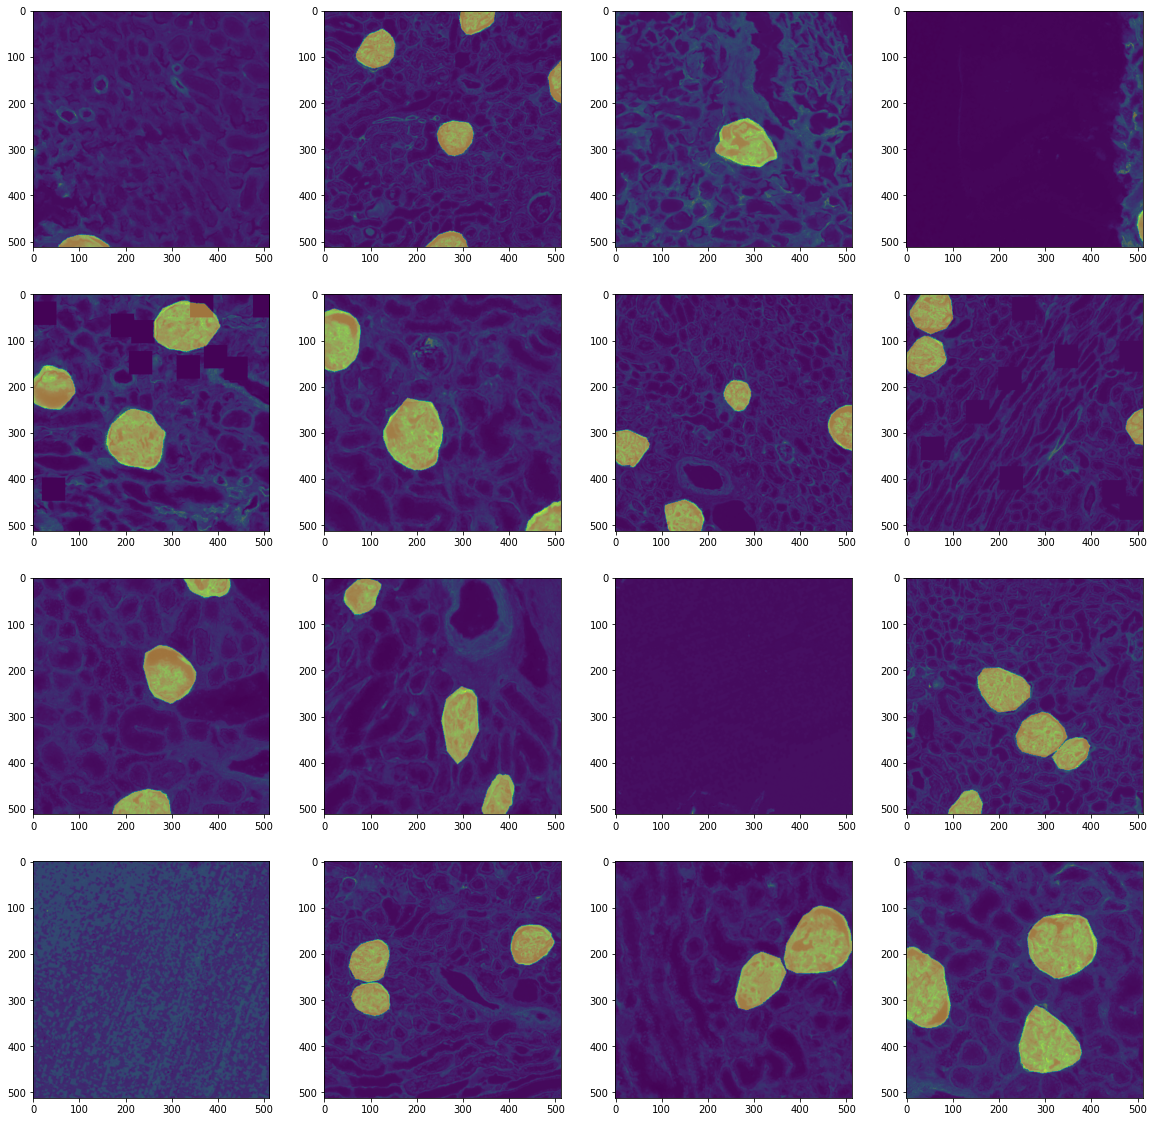

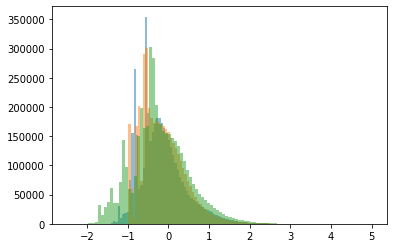

epoch,0.32971
train_loss,1.75694
raw_loss,1.72273
wd_0,0.0
sqr_mom_0,0.99
lr_0,8e-05
mom_0,0.94586
eps_0,0.0
beta_0,0.0
_runtime,713
_timestamp,1628787532


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▇▆▇▆▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
raw_loss,█▇▆██▅▇▇▇▆▇▇▅▆█▆▇▃▅▄▄▆▅▅▇▆▅▅▅▅▄▅▄▅▁▅▃▃▃▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇██
mom_0,███████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Start model fitting <fastai.learner.Learner object at 0x0000022813800220>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,0.921094,1.016288,0.870977,0.771444,0.904259,0.840059,19:14
1,0.140566,0.226705,0.900605,0.819182,0.906579,0.894709,20:14
2,0.099421,0.122357,0.920780,0.853191,0.917277,0.924310,23:00
3,0.088934,0.247431,0.804025,0.672276,0.685164,0.972783,23:32
4,0.085848,0.114846,0.915742,0.844580,0.893075,0.939591,23:30
5,0.079458,0.159508,0.874710,0.777320,0.799047,0.966202,23:52
6,0.077530,0.112436,0.911653,0.837650,0.868044,0.959876,24:14
7,0.071976,0.114162,0.914642,0.842711,0.873184,0.960234,24:05
8,0.072468,0.117293,0.911473,0.837345,0.871337,0.955485,19:07
9,0.071676,0.118386,0.910757,0.836137,0.870600,0.954798,19:25


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.8709772788982265.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.9006049704131989.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.9207804194913906.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function


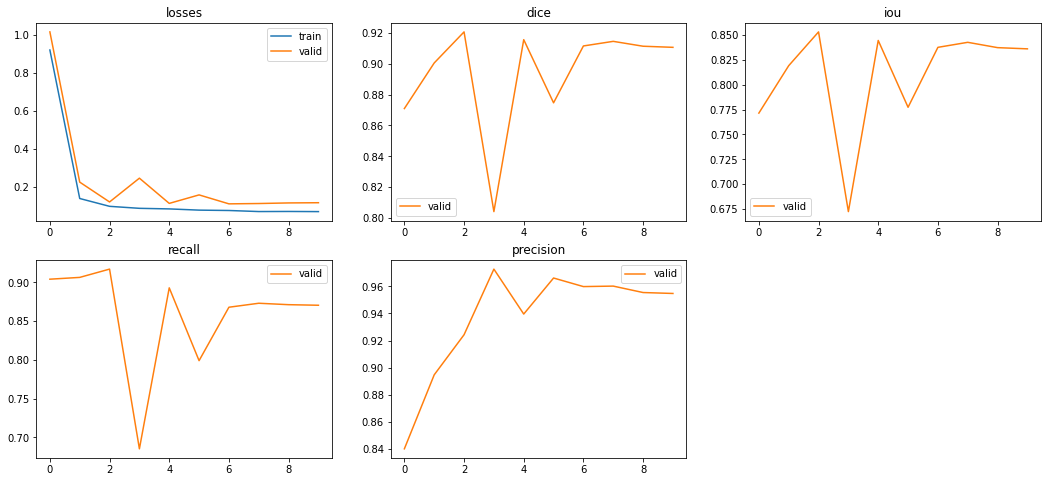

Saving Model
Model Saved
Training on ['2f6ecfcdf', '8242609fa', 'aaa6a05cc', 'cb2d976f4', 'b9a3865fc', '0486052bb', 'e79de561c', '54f2eec69', '4ef6695ce', '26dc41664', 'c68fe75ea', '1e2425f28']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'2f6ecfcdf': (array([0.05121113, 0.02439503, 0.01487128]), array([0.02504121, 0.01812152, 0.00518715])), '8242609fa': (array([0.05035313, 0.02297799, 0.01463727]), array([0.02445109, 0.01958505, 0.00487489])), 'aaa6a05cc': (array([0.0562599 , 0.03461995, 0.01611647]), array([0.03191745, 0.02655209, 0.00598284])), 'cb2d976f4': (array([0.04457629, 0.02537003, 0.01407671]), array([0.02270302, 0.02196148, 0.00468472])), 'b9a3865fc': (array([0.04598673, 0.02200331, 0.01427428]), array([0.02527999, 0.02040572, 0.0053051 ])), '0486052bb': (array([0.05326845, 0.02031053, 0.01618811]), array([0.07242295, 0.02209639, 0.03949639])), 'e79de561c': (array([0.05965046, 0.02820077, 0.02150658]), array([0.02308837, 0.02055834, 0.00568725])), '54f2eec69': (array([0.05531403, 0.03860525, 0.02445441]), array([0.01742642, 0.02596522, 0.00443374])), '4ef6695ce': (array([0.05503173, 0.04874443, 0.02586965]), array([0.02243023, 0.03175157, 0.00777089])), '26dc41664': (array([0.05428959, 0.04618965, 0.0249546

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/696 [00:00<?, ?it/s]

{'b2dc8411c': (array([ 0.48245003, -0.06542967,  0.27264797]), array([0.40616724, 0.06695037, 0.23395064])), '095bf7a1f': (array([ 0.39597847, -0.03657251,  0.22676566]), array([0.25129342, 0.04514753, 0.14467169])), 'afa5e8098': (array([ 0.23239573, -0.01655456,  0.1273603 ]), array([0.21895094, 0.03795714, 0.12583339]))}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,10
train_loss,0.07168
raw_loss,0.056
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
_runtime,13230
_timestamp,1628800767


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss,██▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▇▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Start model fitting <fastai.learner.Learner object at 0x00000228137F0700>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,0.906794,0.979575,0.861466,0.756645,0.820144,0.907173,17:59
1,0.139487,0.538890,0.552017,0.381232,0.609780,0.504251,18:00
2,0.101611,0.125810,0.911479,0.837355,0.900694,0.922524,18:35
3,0.091290,0.251722,0.824563,0.701494,0.713480,0.976613,18:47
4,0.086806,0.141992,0.892851,0.806442,0.846986,0.943969,18:08
5,0.082957,0.123963,0.910872,0.836332,0.870483,0.955192,17:48
6,0.075557,0.120064,0.911301,0.837056,0.882148,0.942448,17:59
7,0.074747,0.132756,0.901702,0.821000,0.853874,0.955207,18:46
8,0.070979,0.120301,0.910780,0.836176,0.873521,0.951359,18:29
9,0.070426,0.122676,0.908981,0.833149,0.871082,0.950328,18:09


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.8614660182087622.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.9114785851075334.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function


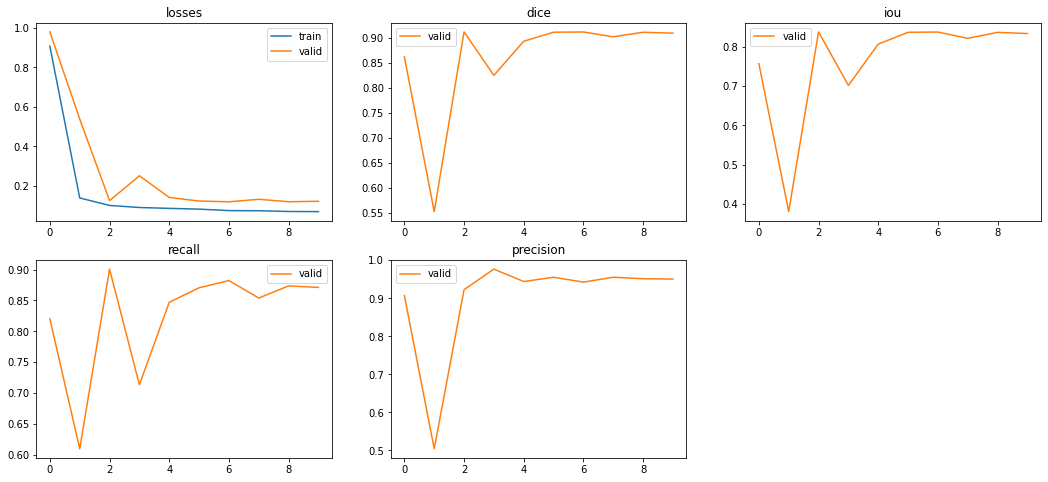

Saving Model
Model Saved
Training on ['2f6ecfcdf', 'cb2d976f4', 'b9a3865fc', 'b2dc8411c', '0486052bb', 'e79de561c', '095bf7a1f', '54f2eec69', '4ef6695ce', '26dc41664', 'c68fe75ea', 'afa5e8098']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'2f6ecfcdf': (array([0.05109145, 0.02433693, 0.01485637]), array([0.02501535, 0.01813108, 0.00518269])), 'cb2d976f4': (array([0.0445257 , 0.02538798, 0.01407263]), array([0.02265905, 0.02196314, 0.00468728])), 'b9a3865fc': (array([0.04610841, 0.02215588, 0.01429493]), array([0.02536   , 0.02047298, 0.00532524])), 'b2dc8411c': (array([0.04699545, 0.01972373, 0.01449634]), array([0.02526173, 0.01878283, 0.00527715])), '0486052bb': (array([0.05046588, 0.02086278, 0.01450607]), array([0.0252265 , 0.01929834, 0.00518985])), 'e79de561c': (array([0.06000528, 0.0285386 , 0.02157843]), array([0.02304106, 0.0206686 , 0.00551684])), '095bf7a1f': (array([0.06114283, 0.05389876, 0.03067446]), array([0.02091062, 0.02928542, 0.00707557])), '54f2eec69': (array([0.05505439, 0.03828974, 0.02433925]), array([0.01737226, 0.02586349, 0.00442204])), '4ef6695ce': (array([0.05531842, 0.049295  , 0.02601553]), array([0.0224942 , 0.03181514, 0.00777879])), '26dc41664': (array([0.05461605, 0.04680266, 0.0251072

  0%|          | 0/609 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

{'8242609fa': (array([ 0.2205061 , -0.01816678,  0.11952424]), array([0.27304219, 0.04669644, 0.15718612])), 'aaa6a05cc': (array([ 0.20404521, -0.01183993,  0.10973103]), array([0.30149415, 0.05275316, 0.17346612])), '1e2425f28': (array([0.20251267, 0.01144259, 0.11717958]), array([0.2182582 , 0.04571454, 0.12549522]))}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,10
train_loss,0.07043
raw_loss,0.0661
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
_runtime,10976
_timestamp,1628812083


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▇▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▇▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Start model fitting <fastai.learner.Learner object at 0x00000228012EFE20>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,0.631124,0.710049,0.897610,0.814239,0.914403,0.881422,17:38
1,0.124132,0.142698,0.910552,0.835792,0.953770,0.871080,16:14
2,0.100184,0.109599,0.922472,0.856100,0.886541,0.961438,17:09
3,0.095563,0.138719,0.897391,0.813879,0.832156,0.973724,17:43
4,0.089995,0.127654,0.906804,0.829498,0.858896,0.960372,17:13
5,0.083310,0.112641,0.917302,0.847237,0.879513,0.958484,17:47
6,0.081485,0.194852,0.853399,0.744285,0.771092,0.955376,16:48
7,0.078613,0.129108,0.901499,0.820662,0.851148,0.958181,16:58
8,0.072553,0.115826,0.912954,0.839849,0.875462,0.953802,17:44
9,0.073576,0.111028,0.917471,0.847525,0.882730,0.955057,16:47


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.8976095036173607.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.9105518227363117.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.9224715603454623.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function


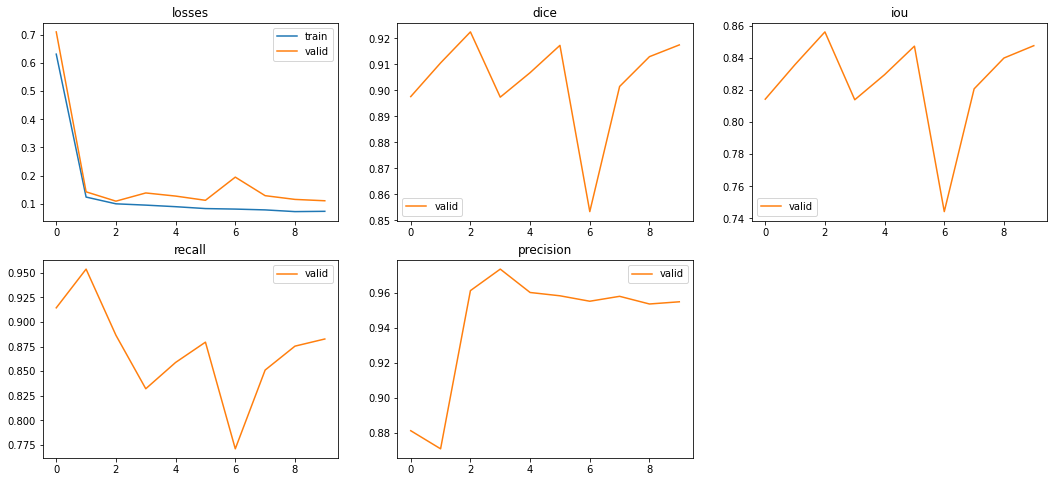

Saving Model
Model Saved
Training on ['2f6ecfcdf', '8242609fa', 'aaa6a05cc', 'cb2d976f4', 'b2dc8411c', '0486052bb', '095bf7a1f', '54f2eec69', '26dc41664', 'c68fe75ea', 'afa5e8098', '1e2425f28']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'2f6ecfcdf': (array([0.05152324, 0.02462644, 0.01491048]), array([0.02510746, 0.01812362, 0.00519889])), '8242609fa': (array([0.05004552, 0.02268697, 0.01459241]), array([0.0242874 , 0.01942036, 0.00485147])), 'aaa6a05cc': (array([0.05854711, 0.0334521 , 0.01775236]), array([0.07579224, 0.02879358, 0.04022101])), 'cb2d976f4': (array([0.0444475 , 0.02524452, 0.01406698]), array([0.02265299, 0.02190348, 0.00469083])), 'b2dc8411c': (array([0.04706022, 0.01977787, 0.01450587]), array([0.025337  , 0.01880061, 0.00529344])), '0486052bb': (array([0.05119322, 0.02053879, 0.01500873]), array([0.04772344, 0.02031104, 0.02380328])), '095bf7a1f': (array([0.06116887, 0.05397582, 0.03073948]), array([0.02094819, 0.02933582, 0.00709051])), '54f2eec69': (array([0.05499169, 0.0382014 , 0.0243363 ]), array([0.01745192, 0.02586096, 0.00444906])), '26dc41664': (array([0.0545768 , 0.04613726, 0.02509437]), array([0.02762749, 0.0293915 , 0.01249652])), 'c68fe75ea': (array([0.0462199 , 0.0227115 , 0.0210205

  0%|          | 0/567 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

{'b9a3865fc': (array([ 0.13330093, -0.00425381,  0.06930104]), array([0.26824125, 0.04620528, 0.1545258 ])), 'e79de561c': (array([0.08420064, 0.01115076, 0.04066921]), array([0.23345555, 0.041508  , 0.13409529])), '4ef6695ce': (array([0.12142757, 0.01465433, 0.06687275]), array([0.20933122, 0.0424318 , 0.12028761]))}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,10
train_loss,0.07358
raw_loss,0.08286
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
_runtime,10336
_timestamp,1628822731


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,██▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Start model fitting <fastai.learner.Learner object at 0x000002288191D7F0>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,1.111006,1.072125,0.855224,0.747066,0.846363,0.864272,16:23
1,0.170959,0.932237,0.271193,0.156867,0.960639,0.157882,17:17
2,0.103775,0.146130,0.900390,0.818826,0.860914,0.943660,16:32
3,0.092168,0.105620,0.923260,0.857459,0.913649,0.933076,16:58
4,0.084152,0.117158,0.921005,0.853577,0.916777,0.925272,17:05
5,0.079440,0.097222,0.929324,0.867978,0.921008,0.937791,16:48
6,0.075120,0.109171,0.921457,0.854354,0.895375,0.949104,17:25
7,0.073861,0.107873,0.921656,0.854695,0.895937,0.948895,15:58
8,0.070058,0.102668,0.924695,0.859937,0.909076,0.940860,16:40
9,0.070473,0.103831,0.924389,0.859408,0.905043,0.944579,15:55


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.8552235865260062.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.9003898679920659.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.9232601688862195.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Better model found at epoch 5 with dice value: 0.9293236096434025.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function


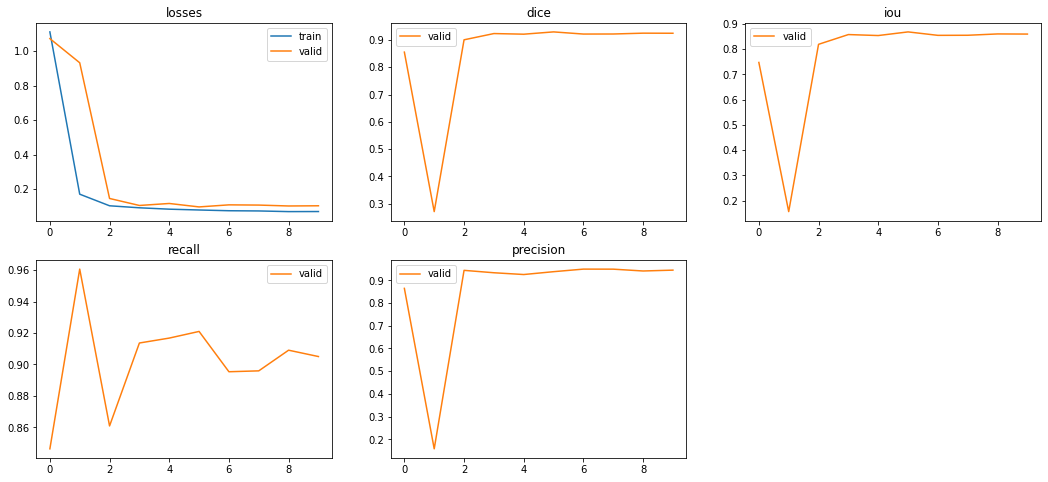

Saving Model
Model Saved
Training on ['2f6ecfcdf', '8242609fa', 'aaa6a05cc', 'b9a3865fc', 'b2dc8411c', 'e79de561c', '095bf7a1f', '54f2eec69', '4ef6695ce', '26dc41664', 'afa5e8098', '1e2425f28']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'2f6ecfcdf': (array([0.05137765, 0.02449162, 0.01488706]), array([0.02509848, 0.01813776, 0.00518759])), '8242609fa': (array([0.05004414, 0.02280293, 0.01459784]), array([0.02427596, 0.01950345, 0.00484909])), 'aaa6a05cc': (array([0.0600581 , 0.03307016, 0.01864854]), array([0.08651969, 0.02943384, 0.04680287])), 'b9a3865fc': (array([0.04618908, 0.02224084, 0.01430423]), array([0.02533569, 0.02052763, 0.00532374])), 'b2dc8411c': (array([0.0470868 , 0.01974104, 0.01451146]), array([0.02533746, 0.01872945, 0.00529532])), 'e79de561c': (array([0.059655  , 0.02825445, 0.02150197]), array([0.02310139, 0.02066597, 0.00568896])), '095bf7a1f': (array([0.0607751 , 0.0533901 , 0.03053501]), array([0.02089098, 0.02942467, 0.00709066])), '54f2eec69': (array([0.05579732, 0.03834392, 0.02478315]), array([0.03887221, 0.02660129, 0.02050718])), '4ef6695ce': (array([0.05509711, 0.04873226, 0.02587689]), array([0.02249789, 0.0318305 , 0.00777103])), '26dc41664': (array([0.0543996 , 0.04630722, 0.0250040

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

{'cb2d976f4': (array([ 0.40440928, -0.05037625,  0.2286794 ]), array([0.25383236, 0.04405733, 0.14626041])), '0486052bb': (array([ 0.41224502, -0.05521472,  0.23202235]), array([0.24007784, 0.04101543, 0.13831388])), 'c68fe75ea': (array([0.04631165, 0.01606352, 0.02148945]), array([0.08323971, 0.02089583, 0.04735613]))}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,10
train_loss,0.07047
raw_loss,0.06126
wd_0,0.0
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
_runtime,10038
_timestamp,1628833106


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,██▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,██▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Start model fitting <fastai.learner.Learner object at 0x00000228531A5280>


epoch,train_loss,valid_loss,dice,iou,recall,precision,time
0,1.014374,1.133127,0.770340,0.626466,0.900301,0.673167,17:58
1,0.135550,0.268156,0.857328,0.750284,0.876003,0.839433,20:09
2,0.098754,0.178515,0.888523,0.799407,0.852443,0.927792,19:16
3,0.090090,0.148799,0.894467,0.809082,0.851124,0.942460,17:43
4,0.084174,0.143365,0.898979,0.816495,0.901666,0.896307,17:47
5,0.079121,0.141025,0.904277,0.825279,0.885265,0.924123,19:00
6,0.077532,0.146533,0.903405,0.823827,0.867913,0.941924,17:33
7,0.074266,0.175257,0.887662,0.798015,0.843451,0.936765,18:13
8,0.074413,0.145371,0.896279,0.812052,0.862914,0.932328,19:02
9,0.073969,0.150423,0.893345,0.807248,0.853520,0.937069,19:17


Generating deformation field
Generating value augmentation function
Better model found at epoch 0 with dice value: 0.7703402695404536.
Generating deformation field
Generating value augmentation function
Better model found at epoch 1 with dice value: 0.8573283686486103.
Generating deformation field
Generating value augmentation function
Better model found at epoch 2 with dice value: 0.8885227134282259.
Generating deformation field
Generating value augmentation function
Better model found at epoch 3 with dice value: 0.8944668615583097.
Generating deformation field
Generating value augmentation function
Better model found at epoch 4 with dice value: 0.8989785518346126.
Generating deformation field
Generating value augmentation function
Better model found at epoch 5 with dice value: 0.9042768621225562.
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmentation function
Generating deformation field
Generating value augmenta

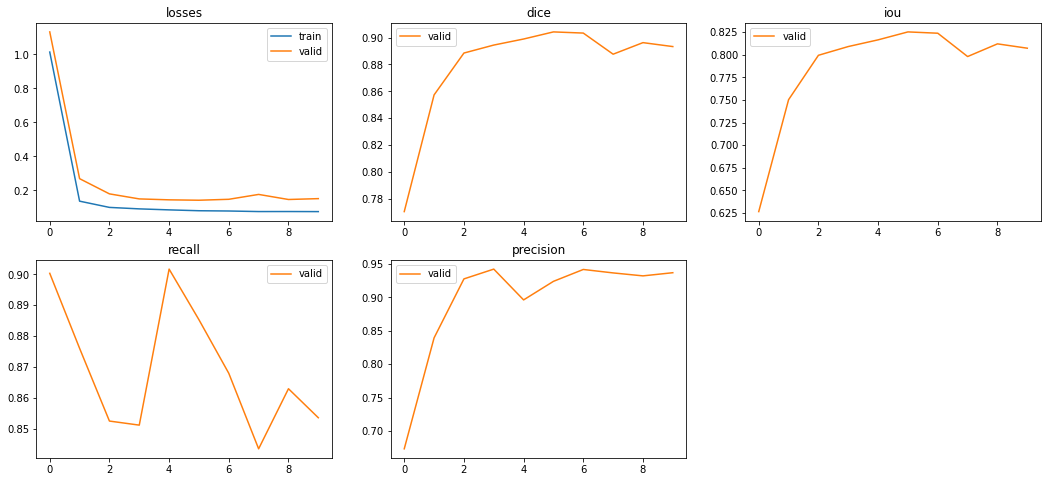

Saving Model
Model Saved


In [12]:
kf = KFold(cfg.n_splits, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(kf.split(files)):
    files_train, files_val = files[train_idx], files[val_idx]
    print('Training on', [x.name for x in files_train])
    
    # Datasets
    train_ds = HubmapRandomTileDataset(files_train, **ds_kwargs, **position_augmentation_kwargs)
    valid_ds = HubmapValidationDataset(files_val, **ds_kwargs)
    
    # Model
    model = smp.Unet(encoder_name=cfg.encoder_name, 
                     encoder_weights=cfg.encoder_weights, 
                     in_channels=cfg.in_channels, 
                     classes=cfg.classes)
    # Dataloader and learner
    dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
    if torch.cuda.is_available(): dls.cuda(), model.cuda()
    
    if i==0: 
        show_batch(dls.one_batch())
        
    run = wandb.init(project='bricknet', reinit=True, config=cfg, name=f"default_with_phils_augment_{i}")

    cbs = [SaveModelCallback(monitor='dice'), ElasticDeformCallback, WandbCallback(log_preds=False, log_model=False)]
    learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs)
    if cfg.mixed_precision_training: learn.to_fp16()
    
    print ("Start model fitting", learn)
    # Fit
    learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
    learn.recorder.plot_metrics()
    
    # Save Model
    print ("Saving Model")
    state = {'model': learn.model.state_dict(), 'stats':cfg.stats}
    torch.save(state, f'models/unet_{cfg.encoder_name}_{i}.pth', pickle_protocol=2, _use_new_zipfile_serialization=False)
    print ("Model Saved")